In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [4]:
ptb_data = pd.read_csv('ptb_data.csv')

# Removing Outliers in PTB Speed

In [20]:
Q1 = ptb_data['DurationSecs'].quantile(0.25)
Q3 = ptb_data['DurationSecs'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
ptb_data = ptb_data[(ptb_data['DurationSecs'] >= lower_bound) & (ptb_data['DurationSecs'] <= upper_bound)]

# Final data setup

In [88]:
df_encoded = ptb_data.drop(columns = ['Anonymize 1PlayerId', 'Player Id', 'ZonePhysical', 'EventName', 'MatchId', 'Tackle', 
                                      'PositionId', 'OppScore', 'Away Score', 'Home Score', 'PTB Tackle Result', 'OfficialId', 'OppPossessionSecs',
                                      'TotalPossessionSecs', 'ElapsedTime', 'PTB Ultimate Outcome', 'SeqNumber', 'Set', 'PTB Defence']) 
# OppPossessionSecs  Official ID

df_encoded = pd.get_dummies(df_encoded, columns=['WeatherConditionName', 'Club Id', 'SeasonId', 'Opposition Id', 'Half', 'PTB Contest', 
                                                 'Raw Tackle Number'], drop_first=True)


df_encoded = df_encoded.dropna()

df_encoded[df_encoded.select_dtypes(include=['bool']).columns] = df_encoded.select_dtypes(include=['bool']).astype(int)

df_encoded.info()


<class 'pandas.core.frame.DataFrame'>
Index: 109805 entries, 0 to 112026
Data columns (total 62 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   DurationSecs                                       109805 non-null  float64
 1   PossessionSecs                                     109805 non-null  float64
 2   Set Type                                           109805 non-null  int64  
 3   Total Involved Tacklers                            109805 non-null  float64
 4   RoundId                                            109805 non-null  int64  
 5   RunOn                                              109805 non-null  int64  
 6   Score                                              109805 non-null  float64
 7   ZonePossession                                     109805 non-null  int64  
 8   GameTime                                           109805 non-null  float64
 9 

# OLS

In [90]:
# RUNNING OLS WITH TRAIN TEST SPLIT
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score

Y = df_encoded['DurationSecs']
X = df_encoded.drop(['DurationSecs'],axis = 1)
X = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=37)

OLS_model = sm.OLS(Y, X).fit()

y_pred = OLS_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}" )

r_squared = r2_score(y_test, y_pred)
print(f"R-squared: {r_squared}")
n = X_test.shape[0]  # Number of observations
p = X_test.shape[1]  # Number of features (predictors)
adjusted_r_squared = 1 - (1 - r_squared) * (n - 1) / (n - p - 1)
print(f"Adjusted_r_squared: {adjusted_r_squared}")

print(OLS_model.summary())

Mean Squared Error: 0.7240801151127758
R-squared: 0.2287697544764945
Adjusted_r_squared: 0.22658616349912408
                            OLS Regression Results                            
Dep. Variable:           DurationSecs   R-squared:                       0.220
Model:                            OLS   Adj. R-squared:                  0.220
Method:                 Least Squares   F-statistic:                     508.3
Date:                Wed, 20 Nov 2024   Prob (F-statistic):               0.00
Time:                        17:03:55   Log-Likelihood:            -1.3793e+05
No. Observations:              109805   AIC:                         2.760e+05
Df Residuals:                  109743   BIC:                         2.766e+05
Df Model:                          61                                         
Covariance Type:            nonrobust                                         
                                                        coef    std err          t      P>|t|      [0

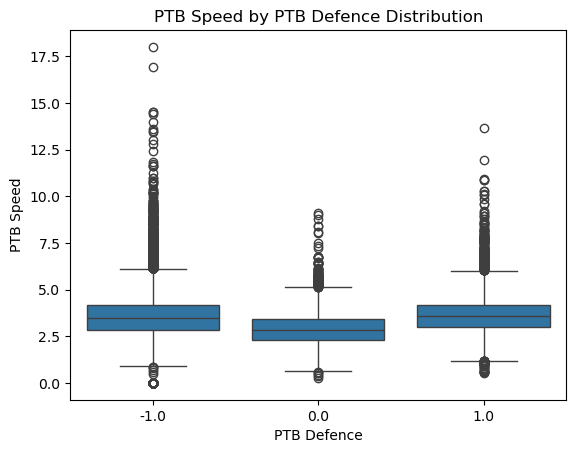

In [18]:
sns.boxplot(x='PTB Defence', y='DurationSecs', data=ptb_data)
plt.title('PTB Speed by PTB Defence Distribution')
plt.xlabel('PTB Defence')
plt.ylabel('PTB Speed')
plt.show()

In [64]:
# RUNNING OLS WITH CROSS-VALIDATION

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_squared_error
import statsmodels.api as sm

Y = df_encoded['DurationSecs']
X = df_encoded.drop(['DurationSecs'],axis = 1)
X = sm.add_constant(X)

ols_model = LinearRegression()

# Perform cross-validation and get MSE scores
cv_mses = -1 * cross_val_score(ols_model, X, Y, cv=5, scoring='neg_mean_squared_error')  # 5-fold cross-validation

cv_mse = cv_mses.mean()

print("Cross-Validation MSE:", cv_mse)

Cross-Validation MSE: 0.7357459140722515


# JOINT F TESTS FOR CATEGORICAL FEATURES:

In [92]:
# Add a constant to the independent variables
X_full = sm.add_constant(X)
X_restricted = sm.add_constant(X.loc[:, ~X.columns.str.startswith('PTB Contest')])

# Fit the modelshow c
model_full = sm.OLS(df_encoded['DurationSecs'], X_full).fit()
model_restricted = sm.OLS(df_encoded['DurationSecs'], X_restricted).fit()

f_test = model_full.compare_f_test(model_restricted)

# Results
print("F-statistic:", f_test[0])
print("p-value:", f_test[1])

F-statistic: 6713.090087258544
p-value: 0.0
